In [1]:
import sys

sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
sys.path.insert(0, '/Volumes/data/LosAlamosSummer/DrOsborneCode')

import Utilities as ut
import importlib
import model as mod
import predict_with_uncertainty as pu
import custom as cus
importlib.reload(ut)
importlib.reload(mod)
importlib.reload(pu)
importlib.reload(cus)
import scipy
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [2]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/LWR/DATA/LWR_data_7.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=ut.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= ut.ProcessData(datapath, 1,1000,0,0,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data



Load Data loads raw data from the .mat file
Inputs
datapath: Path to .mat file containing the data [string]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

ProcessData is the serialization maker 
Inputs
datapath: Path to .mat file containing the data [string]
Percent of data to be used: in most cases full data set will be used but good for analysis [double](0-1)
ndecades: Number of decades wanted in equal lethargy serialization. Number is ignored if custom serialization inputted [int]
mode: equal lethargy mode (0) or custom serialization mode (1) [boolean]
input serial: a custom serialization regime (ignored if mode is not 1) [numpy array]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

In [3]:

#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)
print(np.std(kinfBOL))

(49999,)
49999
(49999, 3)
0.25062617612169336


In [4]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = ut.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 9999)
(3, 4999)
(49999, 3)
(3, 34999)


makeFractions splits the data into appropriatly sized sets
Nsamples is the number of samples of the data set
vldF is the validation fraction
testF is the test fraction
allData is the set of serialzed group structures
y_norm is the kinfs that correspond to the serialized group structures (normalized or otherwise)
BU (the last input) is a boolean determining whether the data contains burnup [Boolean] (used in the same manner as previous)

In [21]:
batch_size=192;
model = tf.keras.Sequential([
    layers.Dense(1053, activation='relu', name='hidden_1', input_dim=999),
    layers.Dense(96, activation='relu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
model.compile(loss="mean_squared_logarithmic_error",metrics="mean_squared_logarithmic_error")
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1053)              1053000   
_________________________________________________________________
hidden_2 (Dense)             (None, 96)                101184    
_________________________________________________________________
output (Dense)               (None, 3)                 291       
Total params: 1,154,475
Trainable params: 1,154,475
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-6))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())

Epoch 1/800
183/183 [==============================] - 2s 9ms/step - loss: 0.1709 - val_loss: 0.1452
Epoch 2/800
183/183 [==============================] - 1s 8ms/step - loss: 0.1022 - val_loss: 0.0745
Epoch 3/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0446 - val_loss: 0.0430
Epoch 4/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0317 - val_loss: 0.0354
Epoch 5/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0265 - val_loss: 0.0351
Epoch 6/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0231 - val_loss: 0.0315
Epoch 7/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0208 - val_loss: 0.0308
Epoch 8/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0189 - val_loss: 0.0288
Epoch 9/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0186 - val_loss: 0.0319
Epoch 10/800
183/183 [==============================] - 1s 8ms/step - loss: 0.0170 - val_lo

183/183 [==============================] - 2s 9ms/step - loss: 0.0053 - val_loss: 0.0184
Epoch 82/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0188
Epoch 83/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0053 - val_loss: 0.0192
Epoch 84/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0055 - val_loss: 0.0187
Epoch 85/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0052 - val_loss: 0.0187
Epoch 86/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0053 - val_loss: 0.0194
Epoch 87/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0052 - val_loss: 0.0187
Epoch 88/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0188
Epoch 89/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0185
Epoch 90/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0047 - val_loss: 

Epoch 161/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.0174
Epoch 162/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0169
Epoch 163/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0039 - val_loss: 0.0169
Epoch 164/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0169
Epoch 165/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0034 - val_loss: 0.0173
Epoch 166/800
183/183 [==============================] - 2s 8ms/step - loss: 0.0034 - val_loss: 0.0169
Epoch 167/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0173
Epoch 168/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0169
Epoch 169/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0170
Epoch 170/800
183/183 [==============================] - 2s 9ms/step - lo

183/183 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0163
Epoch 241/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0163
Epoch 242/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0165
Epoch 243/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0164
Epoch 244/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0162
Epoch 245/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0164
Epoch 246/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0162
Epoch 247/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0171
Epoch 248/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0164
Epoch 249/800
183/183 [==============================] - 2s 9ms/step - loss: 0.0027 - v

In [23]:
y_predicted = model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_average_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
print(metric.result().numpy())
print(y_predicted)

0.0013994994
[[1.3717239  1.0839608  0.88836324]
 [1.3663667  1.0805475  0.88662547]
 [0.8926562  0.63980085 0.4955833 ]
 ...
 [1.3654922  1.0743272  0.8750871 ]
 [1.372577   1.0814513  0.870959  ]
 [0.8136295  0.6143204  0.48565847]]


In [24]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 3)


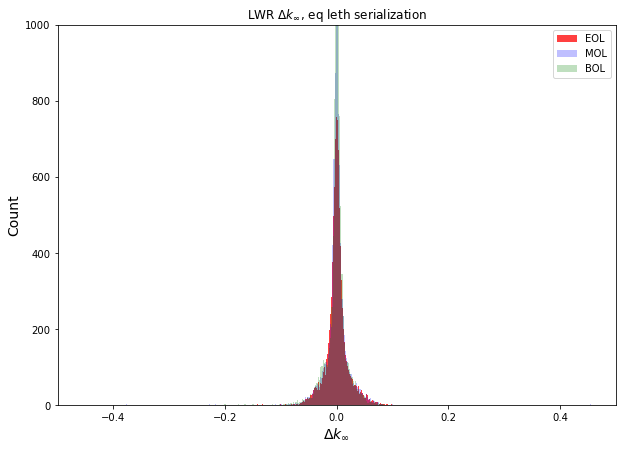

In [25]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=500,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=500,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=500,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("LWR $Δk_{\infty}$, eq leth serialization")
plt.legend(loc='upper right')
plt.xlim([-0.5,0.5])
plt.ylim([0,1000])

plt.savefig("PICS/LWR_deltaK_eqleth_opti.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
# Show plot
plt.show()


In [26]:

print(np.std(a[:,0]))
print(np.std(a[:,1]))
print(np.std(a[:,2]))
print(np.mean([np.std(a[:,0]),np.std(a[:,1]),np.std(a[:,2])]))
print(np.std(a,0))

0.039587860333798894
0.038042128720711874
0.03438322788652094
0.037337738980343906
[0.03958786 0.03804213 0.03438323]


In [27]:
print(y_predicted[:,0])
print(y_predicted.shape)
print(y_test.shape)

[1.3717239 1.3663667 0.8926562 ... 1.3654922 1.372577  0.8136295]
(9999, 3)
(3, 9999)


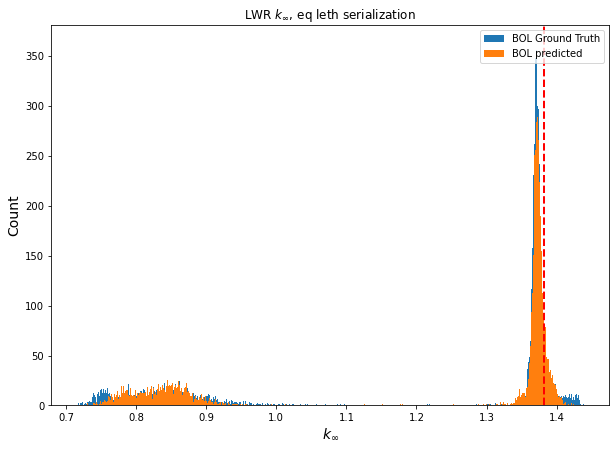

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 1000
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL Ground Truth")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)

plt.legend(loc='upper right')
plt.axvline(1.3815,color='r',linestyle='dashed',linewidth=2)

plt.title("LWR $k_{\infty}$, eq leth serialization")
plt.savefig("PICS/kinfPredDist_eqleth_opti.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
plt.show()
# Show plot



In [29]:
print(np.sum(np.logical_and(kinfBOL > 1.3815-0.001,kinfBOL < 1.3815+0.001))/50000)

print(len(kinfBOL))

0.01676
49999


In [30]:
np.sum(a[:,0]<0.001)

5420

In [31]:
len(a)

9999

In [ ]:
5741/9999
